In [15]:
# Reporting utilities for inference-benchmarker
from __future__ import annotations

import os
from typing import Optional, Dict, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Try to use scienceplots style if available for nicer defaults
try:
    import scienceplots  # noqa: F401

    plt.style.use(["science", "no-latex"])  # fall back to no-latex for portability
except Exception:
    plt.style.use("seaborn-v0_8")

# Column display names aligned with dashboard
COLUMN_MAPPINGS: Dict[str, str] = {
    "inter_token_latency_ms_p90": "ITL P90 (ms)",
    "time_to_first_token_ms_p90": "TTFT P90 (ms)",
    "e2e_latency_ms_p90": "E2E P90 (ms)",
    "token_throughput_secs": "Throughput (tokens/s)",
    "successful_requests": "Successful requests",
    "error_rate": "Error rate (%)",
    "model": "Model",
    "rate": "QPS",
    "run_id": "Run ID",
}

# Metric configuration mirroring extra/dashboard/app.py
METRICS: Dict[str, Dict[str, object]] = {
    "inter_token_latency_ms": {
        "title": "Inter Token Latency (lower is better)",
        "x_title": "QPS",
        "y_title": "Time (ms)",
        "has_percentiles": True,
    },
    "time_to_first_token_ms": {
        "title": "TTFT (lower is better)",
        "x_title": "QPS",
        "y_title": "Time (ms)",
        "has_percentiles": True,
    },
    "e2e_latency_ms": {
        "title": "End to End Latency (lower is better)",
        "x_title": "QPS",
        "y_title": "Time (ms)",
        "has_percentiles": True,
    },
    "token_throughput_secs": {
        "title": "Request Output Throughput (higher is better)",
        "x_title": "QPS",
        "y_title": "Tokens/s",
        "has_percentiles": False,
    },
    "successful_requests": {
        "title": "Successful requests (higher is better)",
        "x_title": "QPS",
        "y_title": "Count",
        "has_percentiles": False,
    },
    "error_rate": {
        "title": "Error rate",
        "x_title": "QPS",
        "y_title": "%",
        "has_percentiles": False,
    },
    "prompt_tokens": {
        "title": "Prompt tokens",
        "x_title": "QPS",
        "y_title": "Count",
        "has_percentiles": False,
    },
    "decoded_tokens": {
        "title": "Decoded tokens",
        "x_title": "QPS",
        "y_title": "Count",
        "has_percentiles": False,
    },
}

# Available percentile suffixes for percentile-based metrics
PERCENTILES: List[str] = ["p50", "p60", "p70", "p80", "p90", "p95", "p99", "avg"]


In [16]:
from __future__ import annotations
from typing import List, Tuple
import pandas as pd
from IPython import get_ipython

import sys
import os
from typing import Optional

# Retrieve mapping from global namespace if defined; fall back to identity
COLUMN_MAPPINGS = (
    get_ipython().user_ns.get("COLUMN_MAPPINGS", {}) if get_ipython() else {}
)


def load_bench_results(source: str) -> pd.DataFrame:
    """Load benchmark results from a local path or s3 path.

    This mirrors extra/dashboard/app.py: load_bench_results and subsequent filters.
    """
    if not (source.startswith("file://") or source.startswith("s3://")):
        raise ValueError(f"Unknown datasource: {source}")

    df = pd.read_parquet(source)
    # remove warmup and throughput
    df = df[(df["id"] != "warmup") & (df["id"] != "throughput")]
    # only keep constant rate
    df = df[df["executor_type"] == "ConstantArrivalRate"]
    return df.reset_index(drop=True)


def compute_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate to the summary table used by the dashboard.

    Columns kept and formatted match the dashboard: run_id, model, rate, *_p90, throughput.
    """
    group_cols = ["model", "run_id", "rate"]
    agg_map = {
        "inter_token_latency_ms_p90": "mean",
        "time_to_first_token_ms_p90": "mean",
        "e2e_latency_ms_p90": "mean",
        "token_throughput_secs": "mean",
        "successful_requests": "mean",
        "error_rate": "mean",
    }
    data = df.groupby(group_cols).agg(agg_map).reset_index()
    # Select and format
    keep = [
        "run_id",
        "model",
        "rate",
        "inter_token_latency_ms_p90",
        "time_to_first_token_ms_p90",
        "e2e_latency_ms_p90",
        "token_throughput_secs",
    ]
    data = data[keep].copy()

    for metric in [
        "inter_token_latency_ms_p90",
        "time_to_first_token_ms_p90",
        "e2e_latency_ms_p90",
        "token_throughput_secs",
    ]:
        data[metric] = data[metric].astype(float).map(lambda x: f"{x:.2f}")

    if COLUMN_MAPPINGS:
        data = data.rename(columns=COLUMN_MAPPINGS)
    return data


def list_models_and_runs(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    models = sorted(df["model"].astype(str).unique().tolist())
    run_ids = sorted(df["run_id"].astype(str).unique().tolist())
    return models, run_ids


In [17]:
from typing import Optional


def _resolve_metric_column(metric: str, percentile: str) -> str:
    if metric not in METRICS:
        raise KeyError(f"Unknown metric: {metric}")
    if METRICS[metric]["has_percentiles"]:
        if percentile == "avg":
            # Dashboard uses a synthesized column name like f"{metric}_['p90',...]" at interaction time.
            # In the reports, use the p90 column as default average view to match the table focus.
            return f"{metric}_p90"
        return f"{metric}_{percentile}"
    return metric


def plot_metric_lines(
    df: pd.DataFrame,
    metric: str,
    model: Optional[str] = None,
    run_ids: Optional[List[str]] = None,
    percentile: str = "avg",
    ax: Optional[plt.Axes] = None,
) -> plt.Axes:
    """Plot a single metric vs QPS with one line per run_id.

    - Filters to a specific model if provided
    - Optionally restricts to specific run_ids
    - Supports percentile-suffixed metrics when applicable
    """
    mcol = _resolve_metric_column(metric, percentile)
    data = df.copy()
    if model is not None:
        data = data[data["model"] == model]
    if run_ids:
        data = data[data["run_id"].astype(str).isin([str(x) for x in run_ids])]

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    for rid, g in data.groupby("run_id"):
        g = g.sort_values("rate")
        if mcol not in g.columns:
            # Skip silently if the chosen percentile column doesn't exist in the data
            continue
        ax.plot(g["rate"], g[mcol], marker="o", label=str(rid))

    title = METRICS[metric]["title"]
    ax.set_title(title)
    ax.set_xlabel(METRICS[metric]["x_title"])  # QPS
    ax.set_ylabel(METRICS[metric]["y_title"])  # units
    ax.grid(True, alpha=0.3)
    ax.legend(title="Run ID", frameon=False)
    return ax


def plot_metrics_grid(
    df: pd.DataFrame,
    metrics: Optional[List[str]] = None,
    model: Optional[str] = None,
    run_ids: Optional[List[str]] = None,
    percentile: str = "avg",
    ncols: int = 2,
    figsize: Tuple[int, int] = (14, 10),
) -> List[plt.Axes]:
    """Plot a grid of metrics for quick comparison.

    Returns the list of axes created in row-major order.
    """
    metrics = metrics or list(METRICS.keys())
    n = len(metrics)
    nrows = (n + ncols - 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)

    axes_list: List[plt.Axes] = []
    for idx, metric in enumerate(metrics):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        plot_metric_lines(
            df, metric, model=model, run_ids=run_ids, percentile=percentile, ax=ax
        )
        axes_list.append(ax)

    # Hide any unused axes
    for j in range(idx + 1, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r][c].set_visible(False)

    fig.tight_layout()
    return axes_list


def build_parquet_from_results(
    results_dir: str,
    results_file: str = "benchmarks.parquet",
    device: Optional[str] = None,
) -> str:
    """Build a parquet file from a directory of JSON results using dashboard parser.

    Returns a file:// URI to the generated parquet.
    """
    dashboard_dir = (
        "/Users/randomradio/src/benchmark/inference-benchmarker/extra/dashboard"
    )
    if dashboard_dir not in sys.path:
        sys.path.append(dashboard_dir)
    try:
        from parse_results import build_results as _build_results
    except Exception as e:
        raise ImportError("Could not import parse_results from extra/dashboard.") from e

    _build_results(results_dir, results_file, device)
    return f"file://{results_file}"


/Users/randomradio/src/benchmark/inference-benchmarker/extra/dashboard/parse_results.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_tmp])
/Users/randomradio/src/benchmark/inference-benchmarker/extra/dashboard/parse_results.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_tmp])
/Users/randomradio/src/benchmark/inference-benchmarker/extra/dashboard/parse_results.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-N

,Run ID,Model,QPS,ITL P90 (ms),TTFT P90 (ms),E2E P90 (ms),Throughput (tokens/s)
0,nim_run,meta-llama/Llama-3.1-8B-Instruct,0.401031,13.47,100.27,14070.31,233.71
1,nim_run,meta-llama/Llama-3.1-8B-Instruct,0.802062,15.92,163.50,16219.70,455.45
2,nim_run,meta-llama/Llama-3.1-8B-Instruct,1.203093,15.80,148.52,15184.80,618.14
3,nim_run,meta-llama/Llama-3.1-8B-Instruct,1.604124,21.07,117.60,23368.58,959.84
4,nim_run,meta-llama/Llama-3.1-8B-Instruct,2.005155,21.73,125.89,20130.65,1101.95
5,nim_run,meta-llama/Llama-3.1-8B-Instruct,2.406186,26.17,157.16,23090.06,1109.88
6,nim_run,meta-llama/Llama-3.1-8B-Instruct,2.807217,29.18,158.45,22234.70,1226.12
7,nim_run,meta-llama/Llama-3.1-8B-Instruct,3.208247,34.19,161.29,28848.01,1462.85
8,nim_run,meta-llama/Llama-3.1-8B-Instruct,3.609278,67.67,215.99,46106.65,1138.51
9,nim_run,meta-llama/Llama-3.1-8B-Instruct,4.010309,97.46,248.30,56550.05,780.00


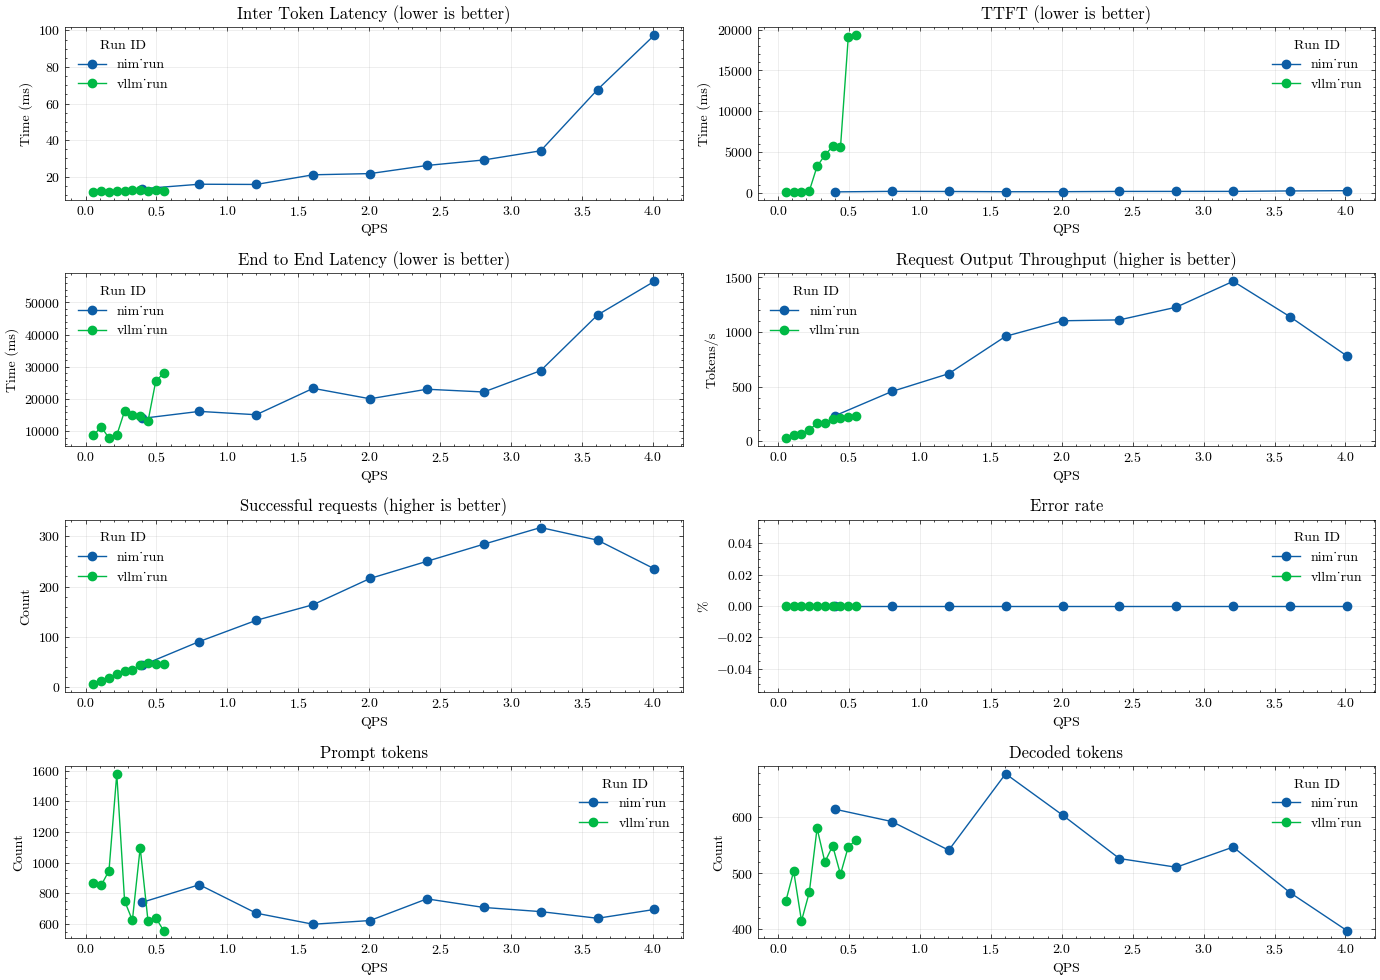

In [18]:
def render_report(
    datasource: Optional[str] = None,
    from_results_dir: Optional[str] = None,
    device: Optional[str] = None,
    model: Optional[str] = None,
    run_ids: Optional[List[str]] = None,
    percentile: str = "avg",
    metrics: Optional[List[str]] = None,
):
    """Render the summary table and a grid of plots from parquet or results dir.

    Provide exactly one of:
    - datasource: file:// or s3:// parquet path (as produced by parse_results)
    - from_results_dir: path to a directory of JSON results; will build a parquet first
    """
    assert percentile in PERCENTILES, f"percentile must be one of {PERCENTILES}"

    if (datasource is None) == (from_results_dir is None):
        raise ValueError("Provide exactly one of datasource or from_results_dir")

    if from_results_dir is not None:
        datasource = build_parquet_from_results(
            from_results_dir, "benchmarks.parquet", device
        )

    df = load_bench_results(datasource)
    models, available_runs = list_models_and_runs(df)

    # Determine default model if not provided
    selected_model = model if model is not None else (models[0] if models else None)

    # Summary table
    summary = compute_summary_table(df)
    display(summary)

    # Plot metrics
    plot_metrics_grid(
        df,
        metrics=metrics,
        model=selected_model,
        run_ids=run_ids,
        percentile=percentile,
    )


render_report(
    from_results_dir="../../../results",  # directory with JSON files
    device=None,
    model=None,
    run_ids=None,
    percentile="avg",
    metrics=None,
)
